## Approximation of the Koopman operator for the triple well 2D potential using 2D Gaussian basis functions

In [18]:
# Important libraries 

import mdtraj as md
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import nglview as nv

import optimal_koopman
import importlib
importlib.reload(optimal_koopman)

from optimal_koopman import OptimalKoopman, get_rcparams, sortEig
plt.rcParams.update(get_rcparams())

from contact_map import ContactFrequency

## Loading the trajectory for Chignolin molecule

In [3]:
# Load the Chignolin data

data_dir = "path_to_data_dcd_files/CLN025-0-protein/"  # path to Chignolin data

traj_names = []             # list to store dcd files

for filename in os.listdir(data_dir):
    
    file_path = os.path.join(data_dir, filename)
    
    traj_names.append(file_path)

In [4]:
# Loading the trajectory and creating time lagged trajectories

t = md.load(traj_names, top='path_to_Chignolin_topology_file\\chignolin_pdb.pdb')

traj_X = t[:-50:50]
traj_Y = t[50::50]

In [5]:
# Creating transformed data matrices using contact maps for the trajectories

dis_X = md.compute_contacts(traj_X, contacts='all', scheme='closest-heavy')
dis_Y = md.compute_contacts(traj_Y, contacts='all', scheme='closest-heavy')

data_X = (dis_X[0]).T
data_Y = (dis_Y[0]).T

In [14]:
# Calculating the step size for GD and initialize the algorithms

C = data_X @ data_X.T                      # C is the hessian of the reconstruction error 
e = np.linalg.eig(C)                      # eigenvalues and eigenvectors of hessian 
L = np.max(e[0])                          
mu = np.min(e[0])                         # minimum eigenvalue of the hessian matrix
h1 = 1/L                                  # step size for gradient descent

epss = 1e-3
loops = 500                                   # Number of iterations of GD
K_init = np.zeros((data_X.shape[0], data_X.shape[0]))   # Initial K matrix

# Calculation of Koopman matrix using EDMD
K_edmd = (data_Y@np.linalg.pinv(data_X)).T     

In [13]:
OptimalK = OptimalKoopman(epss, loops)

# Gradient descent

K_gd, loss_gd = OptimalK.gradient_descent(K_init, data_X, data_Y, h1)

# Stochastic gradient descent

K_sgd, loss_sgd = OptimalK.stochastic_gradient_descent(K_init, data_X, data_Y, h1, batch_size=5000)

# Nesterov test

K_nest, loss_nest = OptimalK.nesterov(K_init, data_X, data_Y, h1)

# ADAM Test

K_adam, loss_adam = OptimalK.adam(K_init, data_X, data_Y, hk=0.01)

## Optimal values graph

In [15]:
# Relative error values plot

opt_val = OptimalK.cost_edmd(K_edmd, data_X, data_Y)
opt_vals_list_gd = (loss_gd - opt_val)/opt_val
opt_vals_list_sgd2 = (loss_sgd - opt_val)/opt_val
opt_vals_list_nest = (loss_nest - opt_val)/opt_val
opt_vals_list_adam = (loss_adam - opt_val)/opt_val


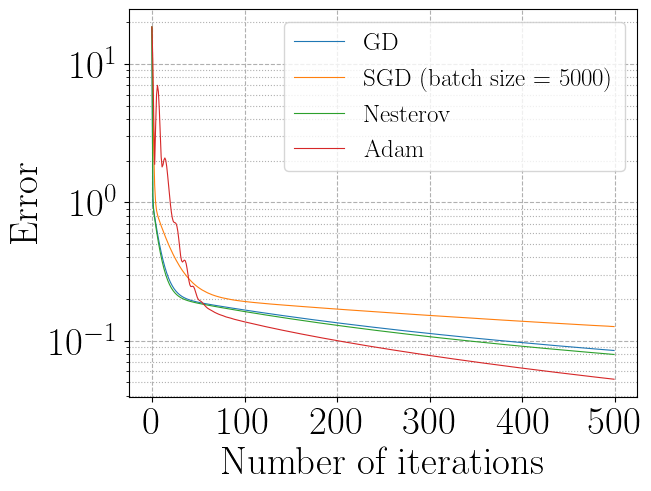

In [16]:
plt.figure()
plt.semilogy(opt_vals_list_gd, linewidth=0.8, label='GD')
plt.semilogy(opt_vals_list_sgd2, linewidth=0.8, label='SGD (batch size = 5000)')
plt.semilogy(opt_vals_list_nest, linewidth=0.8, label='Nesterov')
plt.plot(opt_vals_list_adam, linewidth=0.8, label='Adam')
plt.ylabel('Error', fontsize=28)
plt.xlabel('Number of iterations', fontsize=28)
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#plt.grid('ON')
plt.legend(fontsize=18)
# plt.savefig('loss_chig.pdf')
plt.show()

In [20]:
# Eigendecomposition of approximated K matrix with different GD based algorithms

d1, V1 = sortEig(K_edmd, evs=5)
d2, V2 = sortEig(np.array(K_gd), evs=5)
d3, V3 = sortEig(np.array(K_sgd), evs=5)
d4, V4 = sortEig(np.array(K_nest), evs=5)
d5, V5 = sortEig(np.array(K_adam), evs=5)


c:\Users\tabis\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


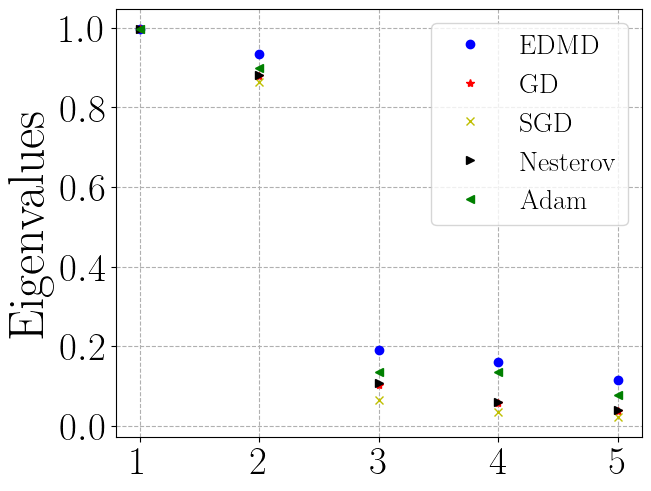

In [ ]:
plt.figure()
xv = np.array([1,2,3,4,5])
plt.plot(xv, d1[:5], 'ob', linewidth=0.1, label='EDMD')
plt.plot(xv, d2[:5], '*r', linewidth=0.1, label='GD')
plt.plot(xv, d3[:5], 'xy', linewidth=0.1, label='SGD')
plt.plot(xv, d4[:5], '>k', linewidth=0.1, label='Nesterov')
plt.plot(xv, d5[:5], '<g', linewidth=0.1, label='Adam')
plt.legend(fontsize=20)
plt.grid(which='major', linestyle='--')
plt.ylabel('Eigenvalues', fontsize=36)
plt.xticks(np.arange(1, 6, step=1), fontsize=28)
plt.yticks(fontsize=28)
# plt.savefig('eigv_chig.pdf')
plt.show()

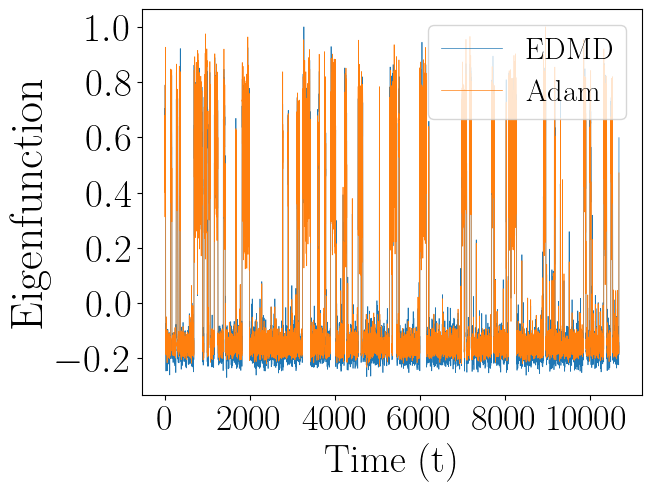

In [23]:
# Visualize the second domianant eigenfunctions

plt.figure()
r1 = V1[:,1].T @ data_X
r2 = V5[:,1].T @ data_X
plt.plot(r1/np.amax(np.abs(r1)), linewidth=0.5, label='EDMD')
plt.plot(r2/np.amax(np.abs(r2)), linewidth=0.5, label = 'Adam')
plt.ylabel('Eigenfunction', fontsize=33)
plt.xlabel('Time (t)', fontsize=28)
plt.legend(fontsize=22, loc='upper right')
plt.xticks(fontsize=26)
plt.yticks(fontsize=28)
# plt.savefig('Eigf_chig.pdf')
plt.show()

In [35]:
# Extract the frames with different configurations using the values of the dominant eigenfunction 

folded = list(i for i, x in enumerate(V2[:,1].T @ data_X) if x > 0.2)
unfolded = list(i for i, x in enumerate(V2[:,1].T @ data_X) if x < -0.5)
part_folded = list(i for i, x in enumerate(V2[:,1].T @ data_X) if x < 0.2 and x > -0.5)

folded_frames = traj_X[folded]
unfolded_frames = traj_X[unfolded]
part_folded_frames = traj_X[part_folded]

## Viewing the trajectory

In [38]:
# Viewing

view = nv.show_file('chignolin_pdb.pdb')    # put the topology file of Chignolin in .pdb format in the working directory
reference = md.load('chignolin_pdb.pdb')

In [39]:
view

NGLWidget()

In [40]:
# Adding the trajectory to the view object 

view.add_trajectory(folded_frames)                        # change "folded_frames" to "unfolded_frames" to visualize unfolded frames
view.add_cartoon('protein', color_scheme = 'residueindex')

# Superpose the trajectory to the reference structure
folded_frames.superpose(reference)
#view.component_1.add_surface(opacity=0.3)
# view.add_representation('cartoon', selection='protein')

<mdtraj.Trajectory with 8133 frames, 166 atoms, 10 residues, and unitcells at 0x1ec9fa18730>

In [41]:
# View the folded/unfolded frames

mat = view._camera_orientation
view._set_camera_orientation(mat)
view.center()
view

NGLWidget(max_frame=8132, n_components=2)

In [66]:
# To download the image

view.download_image(filename='unfolded_Chig.jpg')

## Making a movie (Below is the code to make a gif video for the extracted folded and unfolded frames)

In [81]:
# from time import sleep
# import moviepy.editor as mpy
# from IPython import display

# # For folded frames movie
# i = 0
# for frame in folded:
#     # set frame to update coordinates
#     view.frame = frame
#     i = i + 1
#     sleep(0.5)
#     view.download_image(filename='folded_{}.png'.format(i))

#     sleep(2.0)
#     if i == 30:
#         break

# # For unfolded frames movie
# i = 0
# for frame in unfolded:
#     # set frame to update coordinates
#     view.frame = frame
#     i = i + 1
#     sleep(0.5)
#     view.download_image(filename='unfolded_{}.png'.format(i))
#     sleep(2.0)
#     if i == 30:
#         break


# template_f = 'path_to_folded_frames\\folded_{}.png'

# # get all (sorted) image files
# folded_images = [template_f.format(str(i)) for i in range(1, 30)]


# template_un = 'path_to_unfolded_frames\\unfolded_{}.png'

# # get all (sorted) image files
# unfolded_images = [template_un.format(str(i)) for i in range(1, 30)]

# template_f = 'path_to_folded_frames\\folded_{}.png'

# # get all (sorted) image files
# folded_images = [template_f.format(str(i)) for i in range(1, 30)]


# template_un = 'path_to_unfolded_frames\\unfolded_{}.png'

# # get all (sorted) image files
# unfolded_images = [template_un.format(str(i)) for i in range(1, 30)]

# # make a gif file

# frame_per_second = 2
# im1 = mpy.ImageSequenceClip(folded_images, fps=frame_per_second)
# im1.write_gif('folded_chig.gif', fps=frame_per_second)

# im2 = mpy.ImageSequenceClip(unfolded_images, fps=frame_per_second)
# im2.write_gif('unfolded_chig.gif', fps=frame_per_second)

## Visualizing the contact maps of folded, unfolded and partially folded

In [44]:
# Calculate the contact frequency

folded_contact_freq = ContactFrequency(folded_frames, cutoff=0.5)
unfolded_contact_freq = ContactFrequency(unfolded_frames, cutoff=0.5)
part_folded_contact_freq = ContactFrequency(part_folded_frames, cutoff=0.5)

In [45]:
# Calculate the spm

spm_fold = folded_contact_freq.residue_contacts.sparse_matrix
spm_unfold = unfolded_contact_freq.residue_contacts.sparse_matrix
spm_part_fold = part_folded_contact_freq.residue_contacts.sparse_matrix

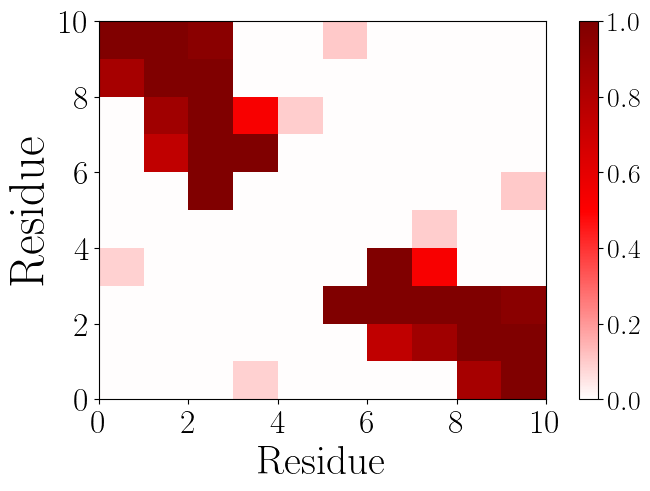

In [46]:
# Plotting the contact frequency over the identified frames

fig, ax = folded_contact_freq.residue_contacts.plot()

plt.xlabel("Residue", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.colorbar(fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=20)
_ = plt.ylabel("Residue", fontsize=35)
# plt.savefig('Folded_contact.jpg')